In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

In [2]:
df=pd.read_csv("monthly_milk_production.csv",index_col='Date',parse_dates=True)
#pandas recognizes that the data is in time format(Date) when we parse_dates
df.index.freq="MS"# which tells the pandas that the Time series is in monthly basis

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


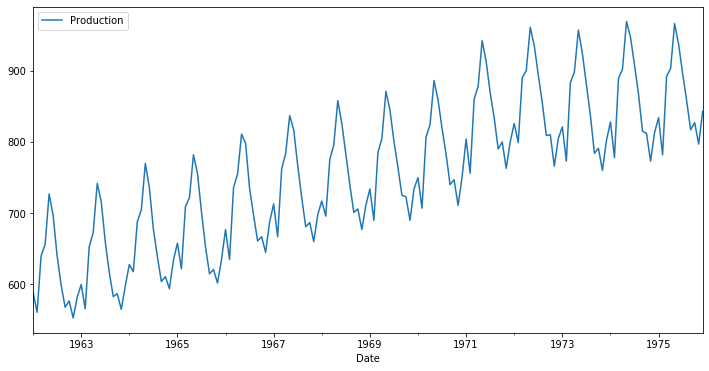

In [4]:
df.plot(figsize=(12,6))

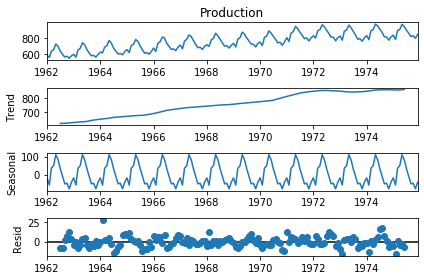

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
results=seasonal_decompose(df['Production'])
results.plot();

In [6]:
len(df)

168

In [8]:
train=df.iloc[:156]
test=df.iloc[156:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()#it scales the data in the range of 0-1


In [10]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [11]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [13]:
from tensorflow import keras


In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [15]:
#define generator
n_input=3
n_features=1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [22]:
X,y=generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
#Here it take 1,2,3 values and predicts 4 and next it takes 2,3,4 and predicts 5
#this is how TimeseriesGenerator helps us

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [19]:
X.shape

(1, 3, 1)

In [23]:
#We do the same but for the 12 months
n_input=12

generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [26]:
#Defining the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit(generator,epochs=50)


Epoch 1/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0447
Epoch 2/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0218
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0160
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0135
Epoch 5/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0094
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 9/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0052
Epoch 10/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 11/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0062
Epoch 12/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0037
Epoch 13/50
144/144 [=

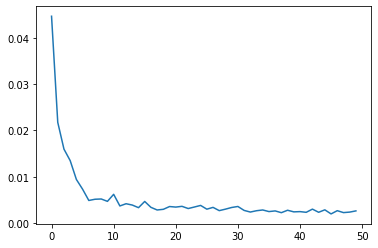

In [29]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [30]:
last_train_batch = scaled_train[-12:]

In [31]:
last_train_batch=last_train_batch.reshape((1,n_input,n_features))

In [32]:
model.predict(last_train_batch)

array([[0.6375216]], dtype=float32)

In [33]:
scaled_test[0]

array([0.67548077])

In [34]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [35]:
test_predictions

[array([0.6375216], dtype=float32),
 array([0.6250361], dtype=float32),
 array([0.80040514], dtype=float32),
 array([0.8729013], dtype=float32),
 array([0.97472006], dtype=float32),
 array([0.96142465], dtype=float32),
 array([0.8923278], dtype=float32),
 array([0.78874487], dtype=float32),
 array([0.6795278], dtype=float32),
 array([0.62924266], dtype=float32),
 array([0.580562], dtype=float32),
 array([0.6135311], dtype=float32)]

In [36]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [37]:
true_predictions=scaler.inverse_transform(test_predictions)

In [38]:
test['Predictions']=true_predictions

D:\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


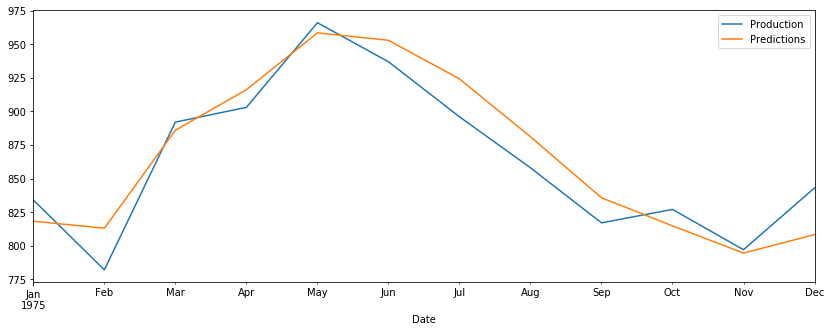

In [39]:
test.plot(figsize=(14,5))

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

19.948046017912624
